# Basic Notebook

**the objective is to go through the first iteration very quickly**

## download the dataset

In [1]:
!pip install huggingface_hub --quiet

In [2]:
from huggingface_hub import snapshot_download
from pathlib import Path

raw_dataset_dir = Path("data/raw/")
interim_dataset_dir = Path("data/interim/")
processed_dataset_dir = Path("data/processed/")

snapshot_download(repo_id="Anuj-Panthri/Image-Colorization-Datasets",
                  repo_type="dataset",
                  local_dir=raw_dataset_dir)

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

forests/readme.txt:   0%|          | 0.00/331 [00:00<?, ?B/s]

forests/test.zip:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

pascal-voc/test.zip:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

forests/trainval.zip:   0%|          | 0.00/26.5M [00:00<?, ?B/s]

pascal-voc/trainval.zip:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

'/kaggle/working/data/raw'

## Prepare the dataset

In [3]:
# unzip data/raw/pascal-voc/trainval.zip & data/raw/pascal-voc/test.zip
# unzip to data/interim/
import os
from zipfile import ZipFile

# sub_dataset_name = "pascal-voc"
sub_dataset_name = "forests"
# os.listdir()
with ZipFile(raw_dataset_dir/Path(f"{sub_dataset_name}/trainval.zip"),"r") as zip:
    zip.extractall(interim_dataset_dir/Path("trainval/"))
    
with ZipFile(raw_dataset_dir/Path(f"{sub_dataset_name}/test.zip"),"r") as zip:
    zip.extractall(interim_dataset_dir/Path("test/"))

In [4]:
# !rm -r {interim_dataset_dir}
!ls -lh {interim_dataset_dir}

total 100K
drwxr-xr-x 2 root root 32K May  5 04:30 test
drwxr-xr-x 2 root root 68K May  5 04:30 trainval


## Clean the dataset

In [5]:
import os
from glob import glob

trainval_dir = interim_dataset_dir / Path("trainval/")
test_dir = interim_dataset_dir / Path("test/")

trainval_paths = glob(str(trainval_dir/Path("*")))
test_paths = glob(str(test_dir/Path("*")))

len(trainval_paths),len(test_paths)

(1864, 762)

is_bw: False


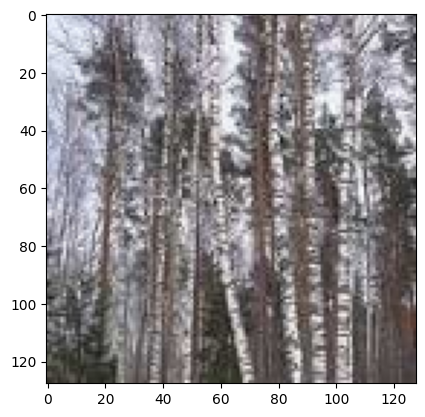

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def is_bw(img):
    rg,gb,rb = img[:,:,0]-img[:,:,1] , img[:,:,1]-img[:,:,2] , img[:,:,0]-img[:,:,2]
    rg,gb,rb = np.abs(rg).sum(),np.abs(gb).sum(),np.abs(rb).sum()
    avg = np.mean([rg,gb,rb])
#     print(rg,gb,rb)
    
    return avg<10
    
    
def show_img(img):
    plt.imshow(img)

img = cv2.imread(trainval_paths[0])[:,:,::-1]
img = cv2.resize(img,[128,128])
# img = np.c_[img[:,:,0:1],img[:,:,0:1],img[:,:,1:2]]
print("is_bw:",is_bw(img))
show_img(img)

In [7]:
from tqdm import tqdm

def get_bw_idxs(image_paths):
    bw_idxs = []
    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img,[128,128])
        if is_bw(img):
            bw_idxs.append(i)
    return bw_idxs

trainval_bw_idxs = get_bw_idxs(trainval_paths)
test_bw_idxs = get_bw_idxs(test_paths)
len(trainval_bw_idxs),len(test_bw_idxs)

100%|██████████| 762/762 [00:00<00:00, 1430.47it/s]


(68, 16)

In [8]:
len(trainval_bw_idxs),len(test_bw_idxs)

(68, 16)

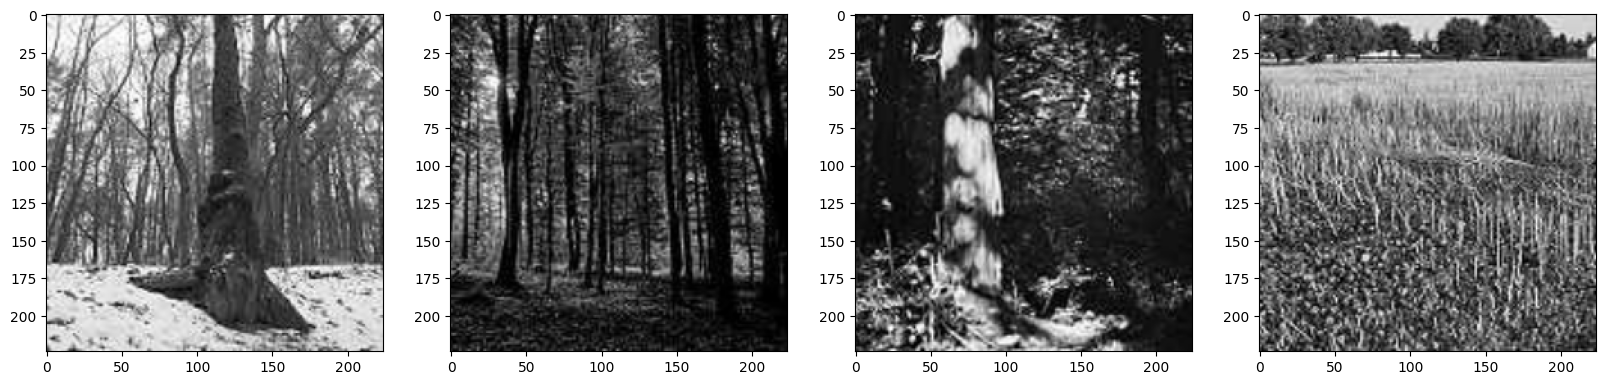

In [9]:
import math

n = 4
cols = 4
rows = math.ceil(n/cols)
fig = plt.figure(figsize=(5*cols,5*rows))
idxs = np.random.choice(trainval_bw_idxs,n)
for i in range(n):
    fig.add_subplot(rows,cols,i+1)
    img = cv2.imread(trainval_paths[idxs[i]])
    img = cv2.resize(img,[224,224])
    show_img(img)
plt.show() 

In [10]:
# copy the valid images to processed_dataset_dir
import shutil
import os

destination_dir = processed_dataset_dir/Path("trainval/")
if os.path.exists(destination_dir): shutil.rmtree(destination_dir)
os.makedirs(destination_dir)    
for i in tqdm(range(len(trainval_paths))):
    if i not in trainval_bw_idxs:
        shutil.copy(trainval_paths[i],
                    destination_dir)

destination_dir = processed_dataset_dir/Path("test/")
if os.path.exists(destination_dir): shutil.rmtree(destination_dir)
os.makedirs(destination_dir)
for i in tqdm(range(len(test_paths))):
    if i not in test_bw_idxs:
        shutil.copy(test_paths[i],
                    destination_dir)

100%|██████████| 762/762 [00:00<00:00, 7527.24it/s]


In [11]:
## clean old interim and raw datasets
import os
import shutil

shutil.rmtree(raw_dataset_dir)
shutil.rmtree(interim_dataset_dir)

## Load Dataset

In [13]:
!pip install comet_ml --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.9/648.9 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 76.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.7.0
    Uninstalling websocket-client-1.7.0:
      Successfully uninstalled websocket-client-1.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.1.6 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.


In [14]:
# use comet for logging
from comet_ml import Experiment
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
COMET_API_KEY = user_secrets.get_secret("comet_api_key")

In [ ]:
# experiment = Experiment(
#   api_key=COMET_API_KEY,
#   project_name="image-colorization",
#   workspace="anujpanthri",
#     auto_histogram_activation_logging=True,
#     auto_histogram_epoch_rate=True,
#     auto_histogram_gradient_logging=True,
#     auto_histogram_weight_logging=True,
#     auto_param_logging=True,
# )

In [15]:
trainval_dir = processed_dataset_dir / Path("trainval/")
test_dir = processed_dataset_dir / Path("test/")

trainval_paths = glob(str(trainval_dir/Path("*")))
test_paths = glob(str(test_dir/Path("*")))

len(trainval_paths),len(test_paths)

(1796, 746)

In [16]:
import sklearn.model_selection


train_paths,val_paths = sklearn.model_selection.train_test_split(trainval_paths,
                                                                 train_size=0.8,
                                                                 random_state=324)
len(train_paths),len(val_paths)

(1436, 360)

In [17]:
pip install -q tensorflow-io

Note: you may need to restart the kernel to use updated packages.


In [18]:
from skimage.color import rgb2lab, lab2rgb
def tf_RGB_TO_LAB(image):
    def f(image):
        image = rgb2lab(image)
        return image
    lab = tf.numpy_function(f,[image],tf.float32)
    lab.set_shape(image.shape)
    return lab

In [19]:
import tensorflow as tf
import tensorflow_io as tfio

IMAGE_SIZE = 224

def scale_L(L):
    return L/100
def rescale_L(L):
    return L*100

def scale_AB(AB):
    return AB/128
#     return AB/255
#     return (AB+128) / 255
def rescale_AB(AB):
    return AB*128
#     return AB*255
#     return AB*255 - 128
# load the image in lab space and split the l and ab channels
def load_img(img_path):
    img_bytes = tf.io.read_file(img_path)
    image = tf.image.decode_image(img_bytes,3,expand_animations=False)
    image = tf.image.resize(image,[IMAGE_SIZE,IMAGE_SIZE])
    image = image / 255.0
#     image = tfio.experimental.color.rgb_to_lab(image)
    image = tf_RGB_TO_LAB(image)
    L,AB = image[:,:,0:1],image[:,:,1:]
    L,AB = scale_L(L),scale_AB(AB)
    return L,AB
    
def get_ds(image_paths,bs=8,shuffle=False,is_val=False):
    ds = tf.data.Dataset.from_tensor_slices(image_paths)
    if shuffle:   ds = ds.shuffle(len(image_paths))
    ds = ds.map(load_img,num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(bs,num_parallel_calls=tf.data.AUTOTUNE,drop_remainder=not is_val)
    
    return ds

train_ds = get_ds(train_paths,shuffle=False)
L_batch,AB_batch = next(iter(train_ds))
L_batch = L_batch.numpy()
AB_batch = AB_batch.numpy()
print("L:",L_batch.min(),L_batch.max())
print("A:",AB_batch[:,:,:,0].min(),AB_batch[:,:,:,0].max())
print("B:",AB_batch[:,:,:,1].min(),AB_batch[:,:,:,1].max())

2024-05-05 04:37:23.491079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 04:37:23.491176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 04:37:23.619166: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


L: 0.0 0.9999277
A: -0.4751531 0.35922694
B: -0.3989991 0.6876104


In [20]:
train_ds.element_spec

(TensorSpec(shape=(8, 224, 224, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(8, 224, 224, 2), dtype=tf.float32, name=None))

## visualize the dataset

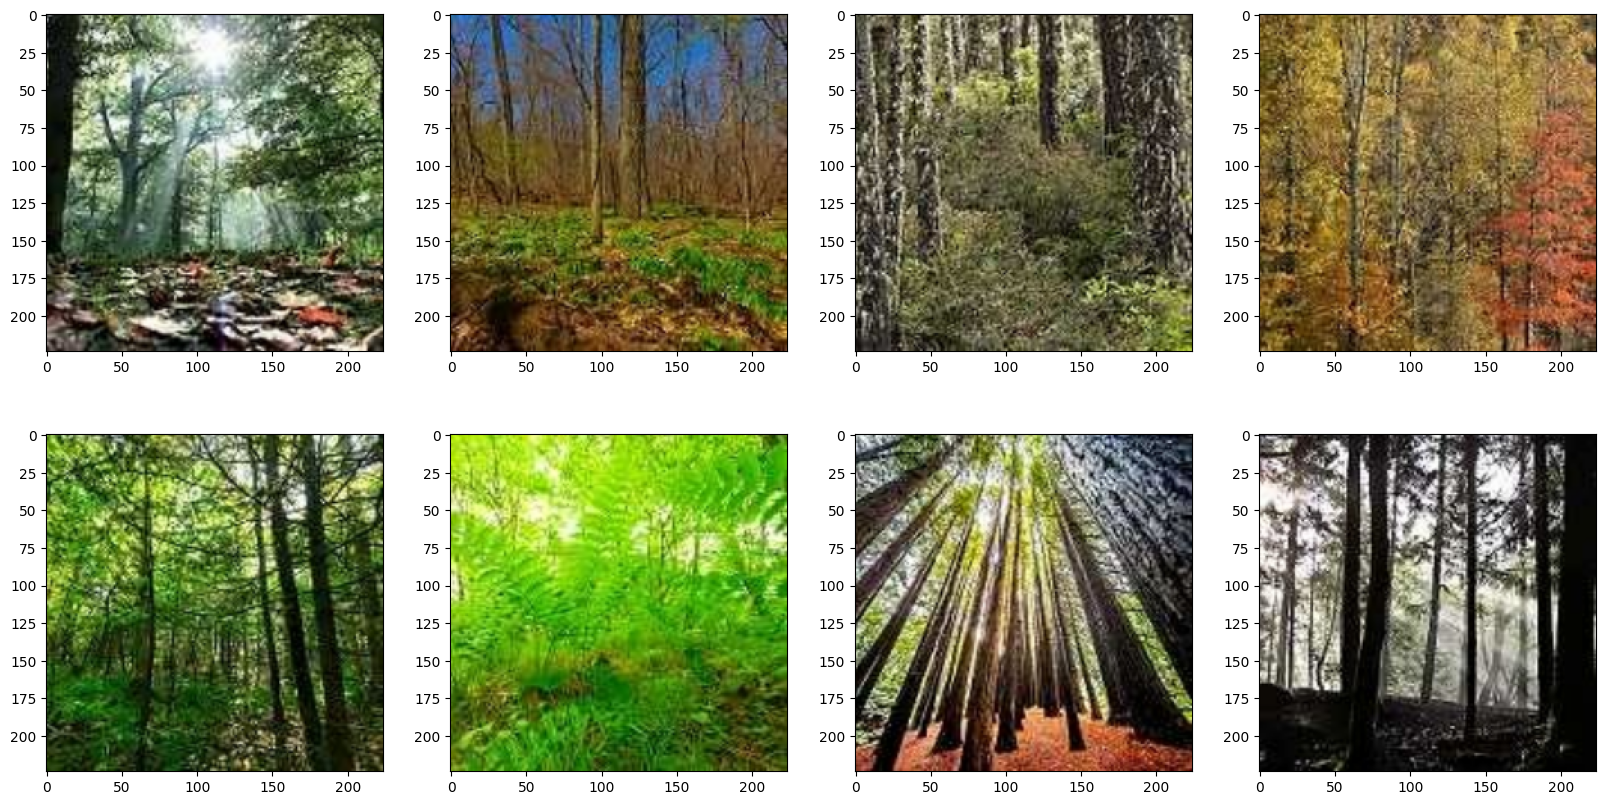

In [22]:
import math

def see_batch(L_batch,AB_batch,show_L=False,cols=4,row_size=5,col_size=5):
    n = L_batch.shape[0]
    rows = math.ceil(n/cols)
    fig = plt.figure(figsize=(col_size*cols,row_size*rows))
    for i in range(n):
        fig.add_subplot(rows,cols,i+1)
        L,AB = L_batch[i],AB_batch[i]
        L,AB = rescale_L(L), rescale_AB(AB)
#         print(L.shape,AB.shape)
        img = np.concatenate([L,AB],axis=-1)
        img = cv2.cvtColor(img,cv2.COLOR_LAB2RGB)*255
#         print(img.min(),img.max())
        if show_L:
            L = np.tile(L,(1,1,3))/100*255
            img = np.concatenate([L,img],axis=1)
        show_img(img.astype("uint8"))
    plt.show()
    
L_batch,AB_batch = next(iter(train_ds))
L_batch,AB_batch = L_batch.numpy(), AB_batch.numpy()
see_batch(L_batch,AB_batch)
# see_batch(L_batch,AB_batch,show_L=True,cols=2,row_size=3,col_size=5)

## Define basic Model

In [50]:
import tensorflow as tf
from tensorflow.keras import layers,Model,Sequential

def down(filters,kernel_size,apply_batch_normalization=True):
    down = Sequential()
    down.add(layers.Conv2D(filters,kernel_size,padding="same",strides=2))
    if apply_batch_normalization:
        down.add(layers.BatchNormalization())
    down.add(layers.LeakyReLU())
    return down

def up(filters,kernel_size,dropout=False):
    upsample = Sequential()
    upsample.add(layers.Conv2DTranspose(filters,kernel_size,padding="same",strides=2))
    if dropout:
        upsample.add(layers.Dropout(dropout))
    upsample.add(layers.LeakyReLU())
    return upsample

In [52]:
def NewUNet():
    x = layers.Input([IMAGE_SIZE,IMAGE_SIZE,1])
    d1 = down(128,(3,3),False)(x)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    d5 = down(512,(3,3),True)(d4)
    
    u1 = up(512,(3,3))(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3))(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3))(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3))(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(64,(3,3))(u4)
    u5 = layers.concatenate([u5,x])
    
    y = layers.Conv2D(2,(2,2),strides = 1, padding = 'same',activation="tanh")(u5)
    return Model(x,y,name="NEWUNET")

model = NewUNet()
model.summary()

Model: "NEWUNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 112, 112,  │      1,280 │ input_layer_17[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 56, 56,    │    147,584 │ sequential_10[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 28, 28,    │    296,192 │ sequential_11[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 14, 14,    │  1,182,208 │ sequential_12[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 7, 7, 512) │  2,361,856 │ sequential_13[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 14, 14,    │  2,359,808 │ sequential_14[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, 14, 14,    │          0 │ sequential_15[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 28, 28,    │  2,359,552 │ concatenate_31[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, 28, 28,    │          0 │ sequential_16[0]… │
│ (Concatenate)       │ 512)              │            │ sequential_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 56, 56,    │    589,952 │ concatenate_32[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_33      │ (None, 56, 56,    │          0 │ sequential_17[0]… │
│ (Concatenate)       │ 256)              │            │ sequential_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_18       │ (None, 112, 112,  │    295,040 │ concatenate_33[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_34      │ (None, 112, 112,  │          0 │ sequential_18[0]… │
│ (Concatenate)       │ 256)              │            │ sequential_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_19       │ (None, 224, 224,  │    147,520 │ concatenate_34[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_35      │ (None, 224, 224,  │          0 │ sequential_19[0]… │
│ (Concatenate)       │ 65)               │            │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 224, 224,  │        522 │ concatenate_35[0

 Total params: 9,741,514 (37.16 MB)

 Trainable params: 9,738,954 (37.15 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [53]:
import tensorflow as tf
from tensorflow.keras import layers,Model

def UNet():
    x = layers.Input([IMAGE_SIZE,IMAGE_SIZE,1])
    
    # encoder
    e1 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    e1 = layers.Dropout(0.2)(e1)
    s1 = layers.Conv2D(32,(3,3),padding="same")(e1)
    e1 = layers.Conv2D(32,(3,3),strides=(2,2),padding="same")(s1)
    e1 = layers.BatchNormalization()(e1)
    e1 = layers.Activation("relu")(e1)
    
    
    e2 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(e1)
    e2 = layers.Dropout(0.2)(e2)
    s2 = layers.Conv2D(64,(3,3),padding="same")(e2)
    e2 = layers.Conv2D(64,(3,3),strides=(2,2),padding="same")(s2)
    e2 = layers.BatchNormalization()(e2)
    e2 = layers.Activation("relu")(e2)

    
    e3 = layers.Conv2D(128,(3,3),activation="relu",padding="same")(e2)
    e3 = layers.Dropout(0.2)(e3)
    s3 = layers.Conv2D(128,(3,3),padding="same")(e3)
    e3 = layers.Conv2D(128,(3,3),strides=(2,2),padding="same")(s3)
    e3 = layers.BatchNormalization()(e3)
    e3 = layers.Activation("relu")(e3)
    
    e4 = layers.Conv2D(256,(3,3),activation="relu",padding="same")(e3)
    e4 = layers.Dropout(0.2)(e4)
    s4 = layers.Conv2D(256,(3,3),padding="same")(e4)
    e4 = layers.Conv2D(256,(3,3),strides=(2,2),padding="same")(s4)
    e4 = layers.BatchNormalization()(e4)
    e4 = layers.Activation("relu")(e4)

    
    e5 = layers.Conv2D(512,(3,3),activation="relu",padding="same")(e4)
    e5 = layers.Dropout(0.2)(e5)
    s5 = layers.Conv2D(512,(3,3),padding="same")(e5)
    e5 = layers.Conv2D(512,(3,3),strides=(2,2),padding="same")(s5)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.Activation("relu")(e5)
    
    e6 = layers.Conv2D(1024,(3,3),padding="same")(e5)
    e6 = layers.BatchNormalization()(e6)
    e6 = layers.Activation("relu")(e6)
    e6 = layers.Dropout(0.2)(e6)
    e6 = layers.Conv2D(1024,(3,3),padding="same")(e6)
    
    # Decoder
    d6 = layers.Conv2DTranspose(512,(2,2),strides=(2,2),padding="same")(e6)
    d6 = layers.concatenate([d6,s5])
    d6 = layers.BatchNormalization()(d6)
    d6 = layers.ReLU()(d6)
    
    d7 = layers.Conv2DTranspose(256,(2,2),strides=(2,2),padding="same")(d6)
    d7 = layers.concatenate([d7,s4])
    d7 = layers.BatchNormalization()(d7)
    d7 = layers.ReLU()(d7)
    
    d8 = layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding="same")(d7)
    d8 = layers.concatenate([d8,s3])
    d8 = layers.BatchNormalization()(d8)
    d8 = layers.ReLU()(d8)
    
    d9 = layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding="same")(d8)
    d9 = layers.concatenate([d9,s2])
    d9 = layers.BatchNormalization()(d9)
    d9 = layers.ReLU()(d9)
    
    d10 = layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding="same")(d9)
    d10 = layers.concatenate([d10,s1])
    d10 = layers.BatchNormalization()(d10)
    
    d11 = layers.Conv2D(16,(1,1))(d10)
    d12 = layers.Conv2D(2,(1,1))(d11)
    d12 = layers.Activation("tanh")(d12)
    
    
    return Model(inputs=x,outputs=d12,name="UNet")

# model = UNet()
# model.summary()

In [54]:
# simple Unet
import tensorflow as tf
from tensorflow.keras import layers,Model

def Simple_UNet():
    x_input = layers.Input([IMAGE_SIZE,IMAGE_SIZE,1])
    
    x=layers.Conv2D(32,(7,7),activation='relu',strides=1,padding='same')(x_input)
    x=layers.Conv2D(32,(7,7),activation='relu',strides=2,padding='same')(x)

    # x=layers.Conv2D(64,(5,5),activation='relu',strides=1,padding='same')(x)
    x=layers.Conv2D(64,(5,5),activation='relu',strides=1,padding='same')(x)
    x=layers.Conv2D(64,(5,5),activation='relu',strides=2,padding='same')(x)


    # x=layers.Conv2D(64,(5,5),activation='relu',strides=1,padding='same')(x)#additional
    # x=layers.Conv2D(64,(3,3),activation='relu',strides=1,padding='same')(x)#additional

    x=layers.Conv2D(64,(3,3),activation='relu',strides=1,padding='same')(x)
    x=layers.Conv2D(64,(3,3),activation='relu',strides=2,padding='same')(x)

    x=layers.UpSampling2D((2,2))(x)
    x=layers.Conv2D(64,(3,3),activation='relu',strides=1,padding='same')(x)
    # x=layers.Add()([x,skip2])
    x=layers.UpSampling2D((2,2))(x)
    x=layers.Conv2D(32,(3,3),activation='relu',strides=1,padding='same')(x)
    # x=layers.Add()([x,skip1])
    x=layers.UpSampling2D((2,2))(x)

    # x=layers.Conv2D(32,(3,3),activation='relu',strides=1,padding='same')(x)#additional
    # x=layers.Conv2D(32,(3,3),activation='relu',strides=1,padding='same')(x)#additional

    y=layers.Conv2D(2,(3,3),activation='tanh',padding='same')(x)
    
    return Model(inputs=x_input,outputs=y,name="Simple_UNet")

# model = Simple_UNet()
# model.summary()

In [55]:
AB_pred = model.predict(L_batch)
print("A:",AB_pred[:,:,:,0].min(),AB_pred[:,:,:,0].max())
print("B:",AB_pred[:,:,:,1].min(),AB_pred[:,:,:,1].max())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
A: -0.12951484 0.08942456
B: -0.13912939 0.15783982


## Define Metrics

In [56]:
from tensorflow.keras import backend as K

def calculate_saturation(L_batch,AB_batch):
    batch_size = L_batch.shape[0]
    L_batch = rescale_L(L_batch)
    AB_batch = rescale_AB(AB_batch)
    lab = tf.concat([L_batch,AB_batch],axis=-1)
    rgb = tfio.experimental.color.lab_to_rgb(lab)
    hsv = tfio.experimental.color.rgb_to_hsv(rgb)
    saturation_batch = tf.reduce_mean(tf.reshape(hsv[:,:,:,1],[batch_size,-1]),axis=-1)
    print(saturation_batch)
    
    
L_batch,AB_batch = next(iter(train_ds))
calculate_saturation(L_batch,AB_batch)

tf.Tensor([0.29563513], shape=(1,), dtype=float32)


## Train the Model

In [70]:
# test run to see if this can fit the first 100 pics from the train dataset
# model = UNet()
model = NewUNet()
# model = Simple_UNet()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss="mse",metrics=["mae","acc"])
model.compile(optimizer="adam",
              loss="mse",metrics=["mae","acc"])

experiment = Experiment(
  api_key=COMET_API_KEY,
  project_name="image-colorization",
  workspace="anujpanthri",
    auto_histogram_activation_logging=True,
    auto_histogram_epoch_rate=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_weight_logging=True,
    auto_param_logging=True,
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/anujpanthri/image-colorization/fce119a4e97d4f6ea97a097e5cf50ef6



In [71]:
# batch_size = 16
# train_ds = get_ds(train_paths,shuffle=True,bs=batch_size)
# train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# history = model.fit(train_ds,epochs=200)

In [72]:
# model.fit(train_ds,epochs=100)

In [73]:
# model = UNet()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#               loss="mse")

batch_size = 16
train_ds = get_ds(train_paths,shuffle=True,bs=batch_size)
val_ds = get_ds(val_paths,shuffle=False,bs=batch_size,is_val=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

history = model.fit(train_ds,validation_data=val_ds,epochs=50)

COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging


Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - acc: 0.8777 - loss: 0.0104 - mae: 0.0768 - val_acc: 0.8808 - val_loss: 0.0098 - val_mae: 0.0766
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - acc: 0.8814 - loss: 0.0092 - mae: 0.0724 - val_acc: 0.8808 - val_loss: 0.0096 - val_mae: 0.0753
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - acc: 0.8831 - loss: 0.0092 - mae: 0.0729 - val_acc: 0.8808 - val_loss: 0.0101 - val_mae: 0.0776
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - acc: 0.8815 - loss: 0.0089 - mae: 0.0709 - val_acc: 0.8808 - val_loss: 0.0089 - val_mae: 0.0709
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - acc: 0.8793 - loss: 0.0088 - mae: 0.0701 - val_acc: 0.8808 - val_loss: 0.0093 - val_mae: 0.0721
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - acc: 0.8824 - loss: 0.0091 - mae: 0.0712 - val_acc: 0.8807 - val_loss: 0.0091 - val_mae: 0.0718
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - acc: 0.8815 - loss: 0.0084 - mae: 0.068

## See the results

L: 0.0 1.0
A: -0.41275203 0.14574158
B: -0.10628526 0.52055377


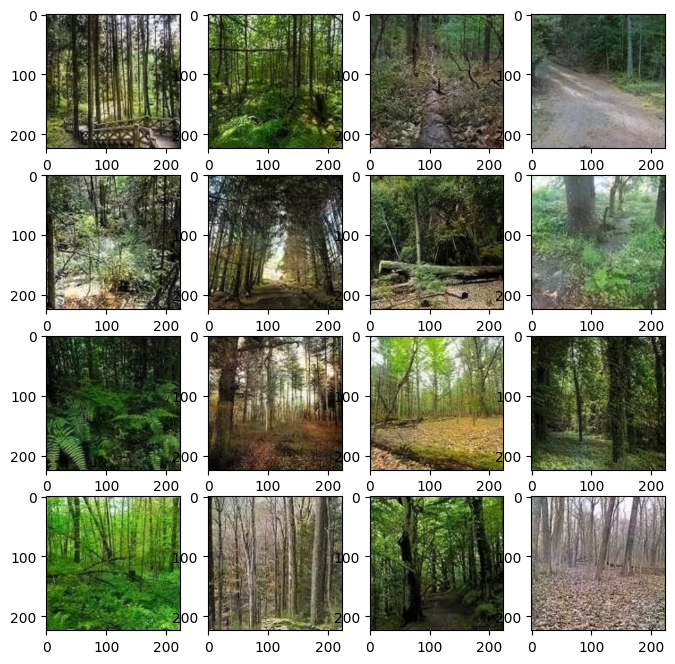

In [74]:
L_batch,AB_true = next(iter(train_ds))
L_batch = L_batch.numpy()
AB_pred = model.predict(L_batch,verbose=0)

print("L:",L_batch.min(),L_batch.max())
print("A:",AB_pred[:,:,:,0].min(),AB_pred[:,:,:,0].max())
print("B:",AB_pred[:,:,:,1].min(),AB_pred[:,:,:,1].max())
# see_batch(L_batch,AB_true,col_size=2,row_size=2)
see_batch(L_batch,AB_pred,col_size=2,row_size=2)
# see_batch(L_batch[:1],AB_pred[:1],col_size=2,row_size=2)

In [79]:
experiment.end()

In [76]:
# for layer in model.layers:
#     print(layer.name)
#     if len(layer.weights)>0:
#         weights,bias = layer.weights
#         weights = weights.numpy()
#         bias = bias.numpy()
#         print(weights.min(),weights.max())
#         print(bias)
#     print()

In [77]:
# model.layers[1].weights[0].numpy()

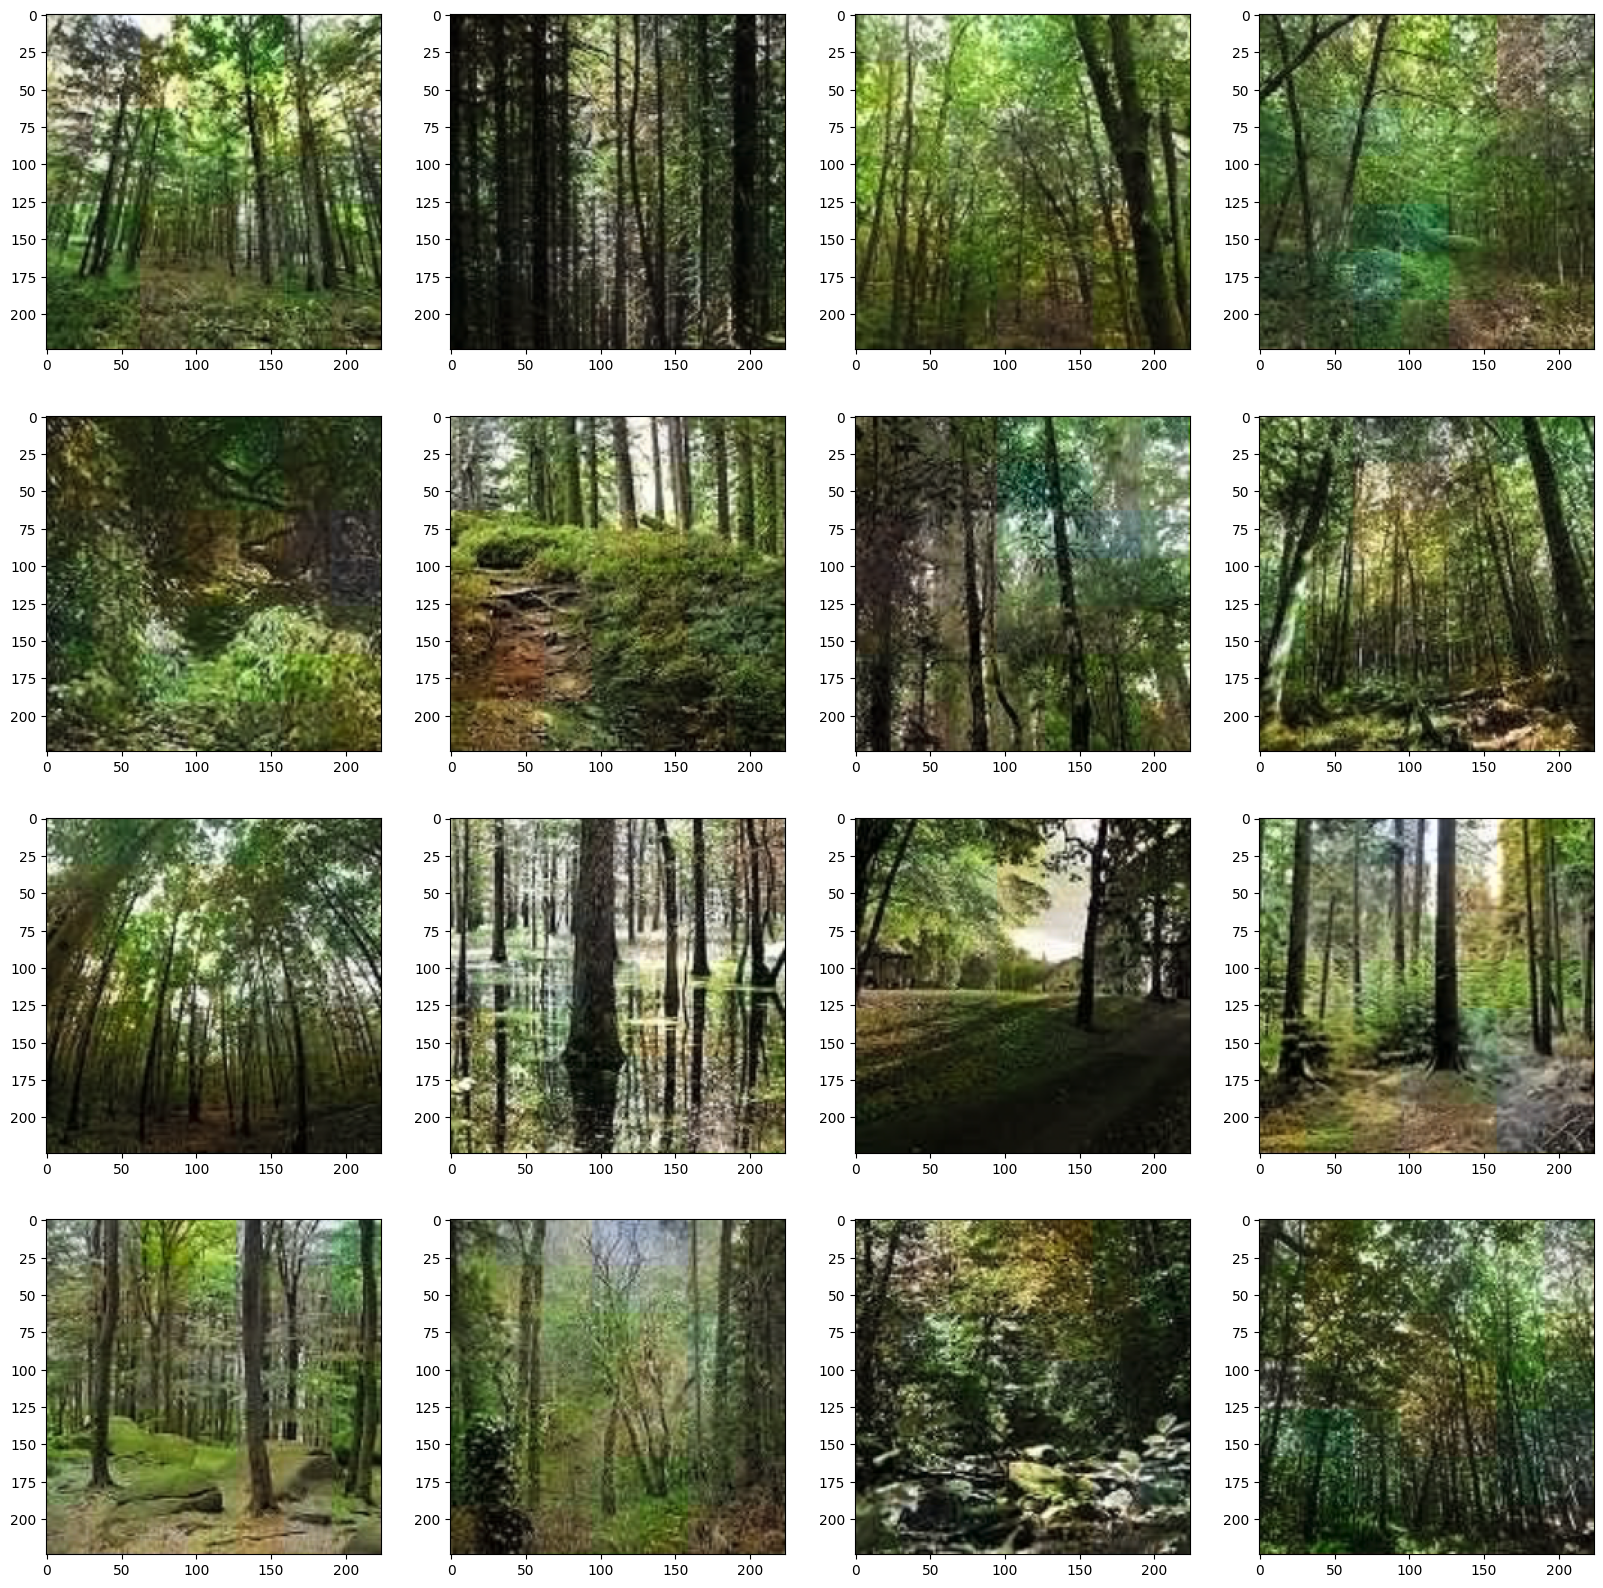

In [78]:
L_batch,AB_true = next(iter(val_ds))
L_batch = L_batch.numpy()
AB_pred = model.predict(L_batch,verbose=0)

# L_batch,AB_pred = rescale_L(L_batch),rescale_AB(AB_pred)
see_batch(L_batch,AB_pred)

## Evaluate on test set

## Save the model weights